In [1]:
from data_utils import get_total_df_from_candles, read_all_candles, read_all_scores
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from submission_utils import get_submission_markowitz, test_submission, general_weights_fixer

In [2]:
from portfoliolab.estimators import ReturnsEstimators, RiskEstimators

In [4]:
from portfoliolab.clustering import HierarchicalRiskParity, HierarchicalEqualRiskContribution
from portfoliolab.clustering import NestedClusteredOptimisation
#cov = risk_estimators.exponential_covariance(df_daily, price_data=True)

In [5]:
candles = read_all_candles()

Getting candles data for Darwins...: 100%|██████████| 96/96 [00:03<00:00, 26.96it/s]


In [6]:
scores = read_all_scores()

100%|██████████| 94/94 [00:02<00:00, 37.72it/s]


In [7]:
def mean_score(df):
    return df["Pf"].mean()

In [8]:
def _compute_weighted_mean(df):
    means = df["Pf"].values  # mean_score
    weights = np.linspace(0.0, 1.0, len(means))
    mean = sum([mu * w / sum(weights) for mu, w in zip(means, weights)]) / len(means)
    return mean

In [9]:
mean_scores = {k: _compute_weighted_mean(v) for k,v in scores.items()}

In [10]:
badscores = [k for k,v in mean_scores.items() if v < 5]

In [11]:
#mean_scores

In [12]:
candles_not_scores = {k:v for k,v in candles.items() if k not in scores}

In [13]:
candles_not_scores.keys()

dict_keys(['MUF', 'MMY'])

In [14]:
candles_scores = {k:v for k,v in candles.items() if k in scores}

In [15]:
candles_closes = {k:v[["close"]] for k, v in candles_scores.items()}

In [16]:
candles_closes["ZVQ"].head()

,close
date,
2018-12-19 01:00:00,519.23
2018-12-19 02:00:00,519.63
2018-12-19 03:00:00,519.95
2018-12-19 04:00:00,520.09
2018-12-19 05:00:00,520.06


In [17]:
def _process_df(df, name):
    df.columns = [name]
    return df

In [18]:
candle_closes = {k: _process_df(v, k) for k, v in candles_closes.items()}

In [19]:
df = pd.concat(candles_closes.values(), keys=candles_closes.keys(), axis=1)

In [20]:
df.head()

,ZVQ,NCT,YAX,OOS,GFJ,FIR,USX,FSK,TMF,TDD,...,AZG,OJG,WWT,BOT,TXR,RAT,DIG,SRI,PHI,RWJ
,ZVQ,NCT,YAX,OOS,GFJ,FIR,USX,FSK,TMF,TDD,...,AZG,OJG,WWT,BOT,TXR,RAT,DIG,SRI,PHI,RWJ
date,,,,,,,,,,,,,,,,,,,,,
2018-12-19 01:00:00,519.23,NaN,NaN,NaN,NaN,NaN,NaN,154.69,NaN,116.07,...,129.87,NaN,129.98,NaN,NaN,140.36,NaN,92.19,NaN,NaN
2018-12-19 02:00:00,519.63,NaN,NaN,NaN,NaN,NaN,NaN,155.01,NaN,116.25,...,129.95,NaN,130.02,NaN,NaN,140.55,NaN,92.11,NaN,NaN
2018-12-19 03:00:00,519.95,NaN,NaN,NaN,NaN,NaN,NaN,155.08,NaN,116.45,...,130.07,NaN,130.10,NaN,NaN,140.51,NaN,92.12,NaN,NaN
2018-12-19 04:00:00,520.09,NaN,NaN,NaN,NaN,NaN,NaN,155.16,NaN,116.65,...,130.26,NaN,130.50,NaN,NaN,140.57,NaN,92.18,NaN,NaN
2018-12-19 05:00:00,520.06,NaN,NaN,NaN,NaN,NaN,NaN,155.23,NaN,116.30,...,130.07,NaN,130.28,NaN,NaN,140.50,NaN,92.07,NaN,NaN


In [21]:
df.columns = df.columns.droplevel()

In [22]:
df.head()

,ZVQ,NCT,YAX,OOS,GFJ,FIR,USX,FSK,TMF,TDD,...,AZG,OJG,WWT,BOT,TXR,RAT,DIG,SRI,PHI,RWJ
date,,,,,,,,,,,,,,,,,,,,,
2018-12-19 01:00:00,519.23,NaN,NaN,NaN,NaN,NaN,NaN,154.69,NaN,116.07,...,129.87,NaN,129.98,NaN,NaN,140.36,NaN,92.19,NaN,NaN
2018-12-19 02:00:00,519.63,NaN,NaN,NaN,NaN,NaN,NaN,155.01,NaN,116.25,...,129.95,NaN,130.02,NaN,NaN,140.55,NaN,92.11,NaN,NaN
2018-12-19 03:00:00,519.95,NaN,NaN,NaN,NaN,NaN,NaN,155.08,NaN,116.45,...,130.07,NaN,130.10,NaN,NaN,140.51,NaN,92.12,NaN,NaN
2018-12-19 04:00:00,520.09,NaN,NaN,NaN,NaN,NaN,NaN,155.16,NaN,116.65,...,130.26,NaN,130.50,NaN,NaN,140.57,NaN,92.18,NaN,NaN
2018-12-19 05:00:00,520.06,NaN,NaN,NaN,NaN,NaN,NaN,155.23,NaN,116.30,...,130.07,NaN,130.28,NaN,NaN,140.50,NaN,92.07,NaN,NaN


In [23]:
df.index.rename("Date", inplace=True)

In [24]:
df_daily = df.resample("D").aggregate("mean")

In [25]:
#after = df_daily.index >= "2020-02-01"
#df_daily = df_daily.loc[after]

In [26]:
hrp = HierarchicalRiskParity()

In [27]:
hrp.allocate(asset_names=df_daily.columns, asset_prices=df_daily)

In [28]:
#constraints = {"XRX": (0.0, 0.10), "ERQ": (0.06, 0.10)}
#hrp.apply_weight_constraints(constraints=constraints)

In [29]:
hrp_weights = hrp.weights.sort_values(by=0, ascending=False, axis=1)

In [36]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 12)
plt.rcParams['axes.labelsize'] = 'xx-large'
plt.rcParams['xtick.labelsize'] = 'x-large'

{'icoord': [[65.0, 65.0, 75.0, 75.0],
  [95.0, 95.0, 105.0, 105.0],
  [165.0, 165.0, 175.0, 175.0],
  [205.0, 205.0, 215.0, 215.0],
  [195.0, 195.0, 210.0, 210.0],
  [315.0, 315.0, 325.0, 325.0],
  [305.0, 305.0, 320.0, 320.0],
  [295.0, 295.0, 312.5, 312.5],
  [365.0, 365.0, 375.0, 375.0],
  [425.0, 425.0, 435.0, 435.0],
  [455.0, 455.0, 465.0, 465.0],
  [445.0, 445.0, 460.0, 460.0],
  [430.0, 430.0, 452.5, 452.5],
  [525.0, 525.0, 535.0, 535.0],
  [515.0, 515.0, 530.0, 530.0],
  [545.0, 545.0, 555.0, 555.0],
  [575.0, 575.0, 585.0, 585.0],
  [565.0, 565.0, 580.0, 580.0],
  [625.0, 625.0, 635.0, 635.0],
  [655.0, 655.0, 665.0, 665.0],
  [645.0, 645.0, 660.0, 660.0],
  [630.0, 630.0, 652.5, 652.5],
  [615.0, 615.0, 641.25, 641.25],
  [605.0, 605.0, 628.125, 628.125],
  [595.0, 595.0, 616.5625, 616.5625],
  [572.5, 572.5, 605.78125, 605.78125],
  [705.0, 705.0, 715.0, 715.0],
  [695.0, 695.0, 710.0, 710.0],
  [685.0, 685.0, 702.5, 702.5],
  [675.0, 675.0, 693.75, 693.75],
  [725.0, 725.

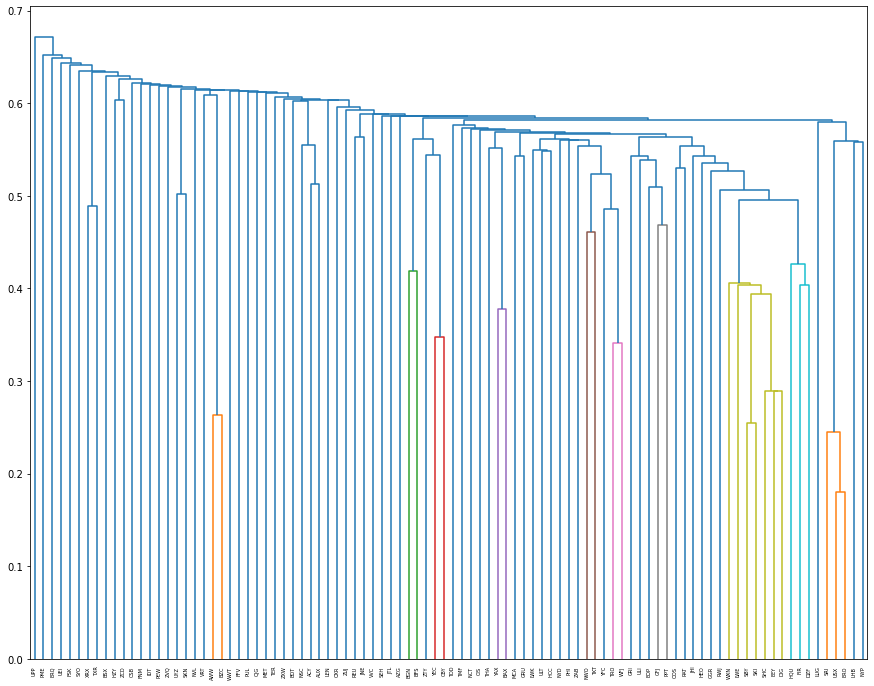

In [37]:
hrp.plot_clusters(assets=df_daily.columns)

In [102]:
hrp_weights

,XRX,ERQ,BSX,CSB,TXR,NCT,IDT,PHI,NYD,PME,...,USX,GFJ,LWE,EEY,GGR,WXN,OOS,DIG,SBY,SKI
0,0.200567,0.048611,0.047382,0.044467,0.04356,0.035558,0.02614,0.019574,0.019015,0.018986,...,0.001569,0.001559,0.001545,0.00142,0.001398,0.001315,0.00124,0.001122,0.000571,0.000554


In [28]:
risk_estimators = RiskEstimators()

In [29]:
cov = risk_estimators.exponential_covariance(df_daily, price_data=True)

In [30]:
return_estimator = ReturnsEstimators()

In [31]:
returns = return_estimator.calculate_exponential_historical_returns(df_daily)

In [32]:
nco = NestedClusteredOptimisation()

In [95]:
returns

ZVQ    0.025839
NCT    0.034006
YAX    0.142309
OOS    0.203846
GFJ    0.124964
         ...   
RAT    0.033257
DIG    0.179604
SRI    0.233964
PHI    0.171153
RWJ    0.050441
Name: 2020-06-17 00:00:00, Length: 94, dtype: float64

In [100]:
assets_cov = df_daily.cov()

# Calculate empirical means of assets
assets_mean = df_daily.mean()

In [105]:
stock_returns = return_estimator.calculate_returns(df_daily)

In [106]:
cov_matrix = stock_returns.cov()

In [109]:
exponential_cov = risk_estimators.exponential_covariance(df_daily, price_data=True,
                                                         window_span=60)

In [1]:
returns = return_estimator.calculate_exponential_historical_returns(df_daily)

NameError: name 'return_estimator' is not defined

In [44]:
# Find optimal weights using the NCO algorithm
w_nco = nco.allocate_nco(cov, returns.values.reshape(-1, 1))

In [45]:
we = w_nco.iloc[0,:].values

In [46]:
#w_nco = np.clip(w_nco, 0, 1)
#w_nco = w_nco / w_nco.sum()

In [49]:
we = np.clip(we, 0, np.inf)

In [52]:
we /= we.sum()

In [54]:
we.sum()

1.0

In [274]:
sum(weights)

1.0

In [275]:
weights.sum()

1.0

In [590]:
weights = hrp_weights.iloc[:, :].values[0]

In [591]:
weights = np.clip(weights, 0, 1)

In [592]:
weights = general_weights_fixer(weights)

In [593]:
weights = weights / sum(weights)

In [544]:
weights = np.around(np.array(weights), 2)

In [557]:
weights = weights / weights.sum()

In [558]:
weights = general_weights_fixer(weights)

In [559]:
weights = np.array(weights)

In [594]:
sum(weights)

1.0

In [595]:
weights

array([0.2002, 0.0486, 0.0474, 0.0445, 0.0436, 0.0356, 0.0261, 0.0196,
       0.019 , 0.019 , 0.0167, 0.0164, 0.0159, 0.0149, 0.0145, 0.0144,
       0.0132, 0.0117, 0.0117, 0.0115, 0.0111, 0.011 , 0.0108, 0.0105,
       0.0099, 0.0096, 0.0096, 0.0095, 0.0094, 0.0093, 0.0091, 0.0089,
       0.0089, 0.0087, 0.0083, 0.0071, 0.007 , 0.007 , 0.0068, 0.0067,
       0.0066, 0.0064, 0.0063, 0.0061, 0.0061, 0.0059, 0.0059, 0.0058,
       0.0052, 0.0051, 0.005 , 0.0047, 0.0047, 0.0045, 0.0045, 0.0045,
       0.0043, 0.0042, 0.0042, 0.0041, 0.0033, 0.0032, 0.0032, 0.0032,
       0.003 , 0.003 , 0.0029, 0.0028, 0.0025, 0.0025, 0.0025, 0.0025,
       0.0024, 0.0023, 0.0023, 0.0022, 0.0022, 0.0022, 0.0022, 0.0021,
       0.002 , 0.0019, 0.0018, 0.0017, 0.0016, 0.0016, 0.0015, 0.0014,
       0.0014, 0.0013, 0.0012, 0.0011, 0.0006, 0.0006])

In [403]:
weights[0] += 9.992007221626409e-16


In [354]:
weights[-1] = 0
weights[-2] = 0

In [58]:
# herc.allocate(asset_prices=df_daily.loc[df_daily.index >= "2020-05-01"], asset_names=df_daily.columns, risk_measure='equal_weighting')

In [63]:
weights_dict = {asset: w for asset, w in zip(w_nco.columns, we)}

In [64]:
sum(weights_dict.values())

1.0

In [57]:
df_daily = df_daily.loc[:, w_nco.columns]

In [58]:
df_daily = df_daily.pct_change()

In [59]:
df_daily_after = df_daily.loc[df_daily.index >= "2020-05-01"]

In [103]:
from tqdm import tqdm
import numpy as np
perc_returns = []

for _, row in tqdm(df_daily_after.iterrows()):
    perc_returns.append(
        np.dot( hrp_weights.iloc[:, :].values[0], row.values)
    )

48it [00:00, 6103.77it/s]


In [80]:
df_daily_after.head()

,XRX,ERQ,BSX,CSB,TXR,NCT,IDT,PHI,NYD,PME,...,USX,GFJ,LWE,EEY,GGR,WXN,OOS,DIG,SBY,SKI
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,-1.110223e-16,0.000000e+00,-1.110223e-16,0.000000,0.000000e+00,0.0,1.222366e-02,0.000477,0.000000e+00,0.000000e+00,...,-0.002401,0.010031,-0.005553,-0.004148,-0.007804,-0.004759,0.000782,-0.004029,0.002217,-0.002165
2020-05-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-03,-1.110223e-16,2.904027e-04,-2.220446e-16,0.000584,4.440892e-16,0.0,4.440892e-16,0.007792,-3.330669e-16,-1.110223e-16,...,-0.001174,0.010720,0.003499,0.003434,-0.003814,0.006312,0.001273,0.002690,0.004671,0.007220
2020-05-04,2.220446e-16,2.220446e-16,4.440892e-16,-0.000862,-5.551115e-16,0.0,-5.551115e-16,0.003710,4.440892e-16,2.220446e-16,...,0.000847,-0.003345,0.000987,0.001572,-0.000796,0.001171,-0.001132,0.001309,0.000021,0.002041
2020-05-05,0.000000e+00,0.000000e+00,0.000000e+00,0.015394,0.000000e+00,0.0,4.984382e-05,-0.001409,0.000000e+00,0.000000e+00,...,0.005622,-0.015140,-0.001148,-0.000214,0.003777,-0.000070,-0.005576,-0.000479,-0.002978,-0.000974


In [104]:
np.std(perc_returns)

0.0010923161462554453

In [105]:
np.mean(perc_returns)

0.00037386377092969524

In [61]:
(np.mean(perc_returns) / np.std(perc_returns))**(2/12)

0.9714071134547694

In [166]:
(np.mean(perc_returns) / np.std(perc_returns))**(2/12)

0.863063612455785

In [108]:
submissionguay = pd.read_csv("submission_2503_2.csv", parse_dates=True, index_col="eod_ts")

In [109]:
test_submission(submissionguay)

In [76]:
submissionguay.columns = [col.replace("allo_", "") for col in submissionguay.columns]

In [77]:
submissionguay = submissionguay.loc[:, df_daily_after.columns]

In [79]:
df_daily_after.head()

,ZVQ,NCT,YAX,OOS,GFJ,FIR,USX,FSK,TMF,TDD,...,AZG,OJG,WWT,BOT,TXR,RAT,DIG,SRI,PHI,RWJ
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,0.005690,0.0,0.012694,0.000782,0.010031,0.0,-0.002401,0.000000e+00,2.220446e-16,0.005728,...,0.005834,3.812844e-04,0.000000e+00,0.000000,0.000000e+00,2.299006e-03,-0.004029,-0.001652,0.000477,0.0
2020-05-02,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.0
2020-05-03,0.000496,0.0,0.002856,0.001273,0.010720,0.0,-0.001174,6.661338e-16,-1.110223e-16,-0.001584,...,-0.000187,2.325903e-04,6.661338e-16,0.005864,4.440892e-16,1.877687e-03,0.002690,0.000139,0.007792,0.0
2020-05-04,0.000050,0.0,0.000000,-0.001132,-0.003345,0.0,0.000847,-5.551115e-16,0.000000e+00,-0.003981,...,-0.000909,-2.220446e-16,-6.661338e-16,-0.001376,-5.551115e-16,-5.551115e-16,0.001309,0.001419,0.003710,0.0
2020-05-05,-0.003053,0.0,0.000000,-0.005576,-0.015140,0.0,0.005622,0.000000e+00,0.000000e+00,-0.006457,...,0.000610,1.462435e-04,0.000000e+00,-0.008279,0.000000e+00,4.929908e-04,-0.000479,0.005453,-0.001409,0.0


In [80]:
perc_returns2 = []

for _, row in tqdm(df_daily_after.iterrows()):
    perc_returns2.append(
        np.dot(submissionguay.iloc[0, :].values, row.values)
    )

48it [00:00, 1967.21it/s]


In [81]:
(np.mean(perc_returns2) / np.std(perc_returns2))**(2/12)

0.8570001428789437

In [82]:
np.std(perc_returns2)

0.0007799789703389651

In [83]:
np.std(perc_returns)

0.0002013606609934709

In [107]:
np.mean(perc_returns2)

0.00030900695855182815

In [65]:
submission = get_submission_markowitz(weights_dict, [k for k in weights_dict.keys()])

In [66]:
test_submission(submission)

In [600]:
sum(submission.iloc[0,:].values)

1.0

In [601]:
submission.iloc[0,:].values.sum()

1.0000000000000004

In [429]:
sum(submissionguay.iloc[0,:].values)

0.9919999996200204

In [430]:
submission.iloc[0,:].values

array([0.2012012 , 0.04904905, 0.04704705, 0.04404404, 0.04404404,
       0.03603604, 0.02602603, 0.02002002, 0.01901902, 0.01901902,
       0.01701702, 0.01601602, 0.01601602, 0.01501502, 0.01401401,
       0.01401401, 0.01301301, 0.01201201, 0.01201201, 0.01201201,
       0.01101101, 0.01101101, 0.01101101, 0.01101101, 0.01001001,
       0.01001001, 0.01001001, 0.01001001, 0.00900901, 0.00900901,
       0.00900901, 0.00900901, 0.00900901, 0.00900901, 0.00800801,
       0.00700701, 0.00700701, 0.00700701, 0.00700701, 0.00700701,
       0.00700701, 0.00600601, 0.00600601, 0.00600601, 0.00600601,
       0.00600601, 0.00600601, 0.00600601, 0.00500501, 0.00500501,
       0.00500501, 0.00500501, 0.00500501, 0.00500501, 0.004004  ,
       0.004004  , 0.004004  , 0.004004  , 0.004004  , 0.004004  ,
       0.003003  , 0.003003  , 0.003003  , 0.003003  , 0.003003  ,
       0.003003  , 0.003003  , 0.003003  , 0.002002  , 0.002002  ,
       0.002002  , 0.002002  , 0.002002  , 0.002002  , 0.00200

In [602]:
submission = submission.div(submission.sum(axis=1), axis=0)

In [376]:
submission.iloc[:,:] = submission.iloc[:,:].astype(float)

In [68]:
test_submission(submission)

In [579]:
sum(submission.iloc[0,:]) == 1

True

In [580]:
submission.iloc[0,:]

allo_XRX    0.200567
allo_ERQ    0.048611
allo_BSX    0.047382
allo_CSB    0.044467
allo_TXR    0.043560
              ...   
allo_WXN    0.001315
allo_OOS    0.001240
allo_DIG    0.001122
allo_SBY    0.000571
allo_SKI    0.000554
Name: 2020-08-18 00:00:00, Length: 94, dtype: float64

In [69]:
submission.to_csv("submission_2403_3.csv", header=True, index=True)

In [73]:
a = pd.read_csv("submission_2503_2.csv", parse_dates=True, index_col="eod_ts")

In [74]:
test_submission(a)

In [72]:
sum(a.iloc[0,:].values) == 1

True

In [613]:
sum(a.iloc[0,:].values)

0.9999999999999996

In [614]:
a.iloc[0,:].values.sum()

1.0

In [575]:
submission.iloc[0,:].values

array([0.2005666 , 0.04861062, 0.04738243, 0.04446701, 0.04355961,
       0.03555834, 0.02614009, 0.01957437, 0.01901543, 0.01898572,
       0.01666086, 0.01642946, 0.01591593, 0.01493625, 0.01448288,
       0.01436122, 0.0132065 , 0.01173341, 0.01171283, 0.01154006,
       0.01107223, 0.01100703, 0.01078057, 0.01051566, 0.00991981,
       0.00958758, 0.00957824, 0.00951851, 0.00944069, 0.00934644,
       0.00914463, 0.00892004, 0.00891912, 0.00871447, 0.00829164,
       0.00709205, 0.0070291 , 0.00700185, 0.00683988, 0.00667199,
       0.00662315, 0.00635535, 0.00625462, 0.00607423, 0.00605337,
       0.00587686, 0.00586499, 0.00575474, 0.0052153 , 0.00509489,
       0.00499929, 0.00466678, 0.00466216, 0.00450099, 0.00449135,
       0.00447883, 0.00425388, 0.00423706, 0.00417225, 0.00406327,
       0.00330619, 0.0032486 , 0.00321901, 0.00316166, 0.00304639,
       0.00297742, 0.00289238, 0.00283554, 0.00249584, 0.00248544,
       0.00246092, 0.00245871, 0.00240359, 0.00229642, 0.00227

In [589]:
a.iloc[0,:].values

array([0.2005666 , 0.04861062, 0.04738243, 0.04446701, 0.04355961,
       0.03555834, 0.02614009, 0.01957437, 0.01901543, 0.01898572,
       0.01666086, 0.01642946, 0.01591593, 0.01493625, 0.01448288,
       0.01436122, 0.0132065 , 0.01173341, 0.01171283, 0.01154006,
       0.01107223, 0.01100703, 0.01078057, 0.01051566, 0.00991981,
       0.00958758, 0.00957824, 0.00951851, 0.00944069, 0.00934644,
       0.00914463, 0.00892004, 0.00891912, 0.00871447, 0.00829164,
       0.00709205, 0.0070291 , 0.00700185, 0.00683988, 0.00667199,
       0.00662315, 0.00635535, 0.00625462, 0.00607423, 0.00605337,
       0.00587686, 0.00586499, 0.00575474, 0.0052153 , 0.00509489,
       0.00499929, 0.00466678, 0.00466216, 0.00450099, 0.00449135,
       0.00447883, 0.00425388, 0.00423706, 0.00417225, 0.00406327,
       0.00330619, 0.0032486 , 0.00321901, 0.00316166, 0.00304639,
       0.00297742, 0.00289238, 0.00283554, 0.00249584, 0.00248544,
       0.00246092, 0.00245871, 0.00240359, 0.00229642, 0.00227

In [87]:
herc = HierarchicalEqualRiskContribution()


In [91]:
df_not_na = df_daily.dropna()

In [90]:
herc.allocate()

ValueError: Distance matrix 'X' must be symmetric.

In [111]:
a = pd.read_csv("prueba.csv", parse_dates=True, index_col="eod_ts")

In [112]:
test_submission(a)

AssertionError: 

In [114]:
a.head(100)

,allo_ACY,allo_AUX,allo_AWW,allo_AZG,allo_BAX,allo_BFS,allo_BGN,allo_BOT,allo_BSX,allo_BZC,...,allo_XRX,allo_YAX,allo_YEC,allo_YFC,allo_ZAB,allo_ZCD,allo_ZTY,allo_ZUJ,allo_ZVQ,allo_ZXW
eod_ts,,,,,,,,,,,,,,,,,,,,,
2020-08-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-18 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-18 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-18 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-18 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-23 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-24 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-24 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
